In [4]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Iterable
from copy import deepcopy

c:\Users\Benoit\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## I) Déplacer un Tensor sur GPU

## II) Déplacer un Module sur GPU

## III) Les convolutions

## Exercice I

Définir et entraîner un modèle de classification d'images

In [ ]:
x = np.load("../datasets/CIFAR10/CIFAR-10.npy")
y = np.load("../datasets/CIFAR10/CIFAR-10-labels.npy")
labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [ ]:
def split(*args: tuple[np.ndarray], fracs: tuple[float] = (0.7, 0.15, 0.15)) -> list[tuple[np.ndarray]]:
    """
    split data in 
    """
    total = sum(fracs)
    fracs = tuple(f/total for f in fracs)
    L = len(args[0])
    indexes = np.random.permutation(L)
    start = 0
    results = []
    for f in fracs:
        end = start + int(f*L)
        results.append(tuple(array[indexes[start:end]] for array in args))
    return results



In [ ]:
train_data, val_data, test_data = split(x, y)

In [ ]:
x_test, y_test = test_data
f, axes = plt.subplots(figsize=[10, 10], nrows=3, ncols=3)
i = 0
for axs in axes:
    for ax in axs:
        ax.imshow(x_test[i].transpose(1, 2, 0))
        ax.axis("off")
        ax.set_title(labels[y_test[i]])
        i += 1

In [ ]:
class Block(torch.nn.Module):
    """
    A block is a set of convolution/max pooling/activation/batch normalization
    """

    def __init__(self, in_features: int, out_features: int, activation: Callable = torch.relu, kernel_size: tuple[int] = (3, 3), pool: tuple[int, int] = (2, 2)):
        super().__init__()
        self.convolution = torch.nn.Conv2d(in_features, out_features, kernel_size, (1, 1), padding="same")
        self.pool = torch.nn.MaxPool2d(pool)
        self.activation = activation
        self.batch_norm = torch.nn.BatchNorm2d(out_features)
    
    def forward(self, X):
        return self.batch_norm(self.activation(self.pool(self.convolution(X))))


class ImageClassifier(torch.nn.Module):
    """
    An Image classifier is a CNN that classifies Images
    """

    def __init__(self, in_features: int, n_classes: int, features: list[int], activation: Callable = torch.relu, kernel_size: tuple[int] = (3, 3), pool: tuple[int, int] = 2):
        super().__init__()
        self.blocks = torch.nn.ModuleList()
        for out_features in features:
            self.blocks.append(Block(in_features, out_features, activation, kernel_size, pool))
            in_features = out_features
        self.output = torch.nn.Conv2d(out_features, n_classes, kernel_size=(1, 1), padding="same")
    
    def forward(self, X):
        """
        Parameters
        ----------
        X : torch.Tensor
            tensor of floats of shape (N, C, H, W)
        """
        X = X.to(self.device)
        for block in self.blocks:
            X = block(X)
        X = self.output(X)
        N, C, H, W = X.shape
        return X.reshape(N, C, -1).mean(dim=-1)

    def predict(self, X: torch.Tensor):
        self.eval()
        with torch.no_grad():
            Y = self(X)
        return Y.max(dim=1).indices

    @property
    def device(self) -> torch.device:
        return self.output.weight.device

In [ ]:
def accuracy(predicted: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    """
    returns the accuracy metric of a prediction
    """
    assert predicted.shape == target.shape
    return torch.sum(predicted == target).detach().cpu().item()/len(target)

def inputs_to_tensor(x, device: torch.device = "cuda:0") -> torch.Tensor:
    """
    converts an image array input into tensor
    """
    return torch.tensor(x/255., dtype=torch.float32, device=device)

def target_to_tensors(y: np.ndarray, device: torch.device = "cuda:0") -> torch.Tensor:
    """
    converts a target numpy array to tensor
    """
    return torch.tensor(y, dtype=torch.long, device=device)

def arrays_to_tensors(x: np.ndarray, y: np.ndarray, device: torch.device = "cuda:0") -> tuple[torch.Tensor]:
    """
    transforms numpy arrays to tensors
    """
    return (inputs_to_tensor(x, device), target_to_tensors(y, device))

def batchifyer(*args: tuple[np.ndarray], device: torch.device = "cuda:0", n_batches: int = 1, batch_size: int = 100) -> Iterable[torch.Tensor]:
    """
    transforms numpy array into batches of torch tensor
    """
    L = len(args[0])
    indexes = np.random.permutation(L)
    for i in range(n_batches):
        x, y = (array[indexes[i*batch_size:(i+1)*batch_size]] for array in args)
        yield arrays_to_tensors(x, y, device=device)

In [ ]:
def train_loop(model: torch.nn.Module, optimizer: torch.optim.Optimizer, train_data: tuple[torch.Tensor], val_data: tuple[torch.Tensor], n_steps: int = 1000, n_batches: int = 1, batch_size: int = 100, patience: int = 100, keep_best: bool = True):
    """
    train the model for the specified number of steps, or untilearly stopping
    """
    best_state = deepcopy(model.state_dict())
    best_step = 0
    best_metric = 0.
    try:
        for step in range(n_steps):
            optimizer.zero_grad()
            # train loss
            model.train()
            losses = []
            for batch in batchifyer(*train_data, device=model.device, n_batches=n_batches, batch_size=batch_size):
                x, y = batch
                y_pred = model(x)
                loss = F.cross_entropy(y_pred, y)
                loss.backward()
                losses.append(loss.item())
            loss = sum(losses)/len(losses)
            # val metric
            model.eval()
            metrics = []
            for batch in batchifyer(*val_data, device=model.device, n_batches=n_batches, batch_size=batch_size):
                x, y = batch
                y_pred = model.predict(x)
                metrics.append(accuracy(y_pred, y))
            metric = sum(metrics) / len(metrics)
            # checkpointing
            if metric > best_metric:
                best_metric = metric
                best_step = step
                if keep_best:
                    best_state = deepcopy(model.state_dict())
            elif step - best_step > patience:
                print("early stoping")
                break
            # optimizer steping
            optimizer.step()
            # printing
            print(f"Step {step}: loss = {loss:.3g} accuracy = {metric:.2%}")

    except KeyboardInterrupt:
        print("interrupted by user")
    if keep_best:
        model.load_state_dict(best_state)

In [ ]:
model = ImageClassifier(3, len(labels), [32, 64, 128, 256])
model.to("cuda:0")
optimizer = torch.optim.Adam(model.parameters(), lr=1.0E-3)
train_loop(model, optimizer, train_data, val_data, n_steps=10000, n_batches=1, batch_size=10000, patience=1000)

In [ ]:
x, y = arrays_to_tensors(*test_data)
y_pred = model.predict(x)
print(accuracy(y_pred, torch.tensor(y, device=y_pred.device)))

In [ ]:
x_test, y_test = test_data
f, axes = plt.subplots(figsize=[10, 10], nrows=3, ncols=3)
i = 0
for axs in axes:
    for ax in axs:
        ax.imshow(x_test[i].transpose(1, 2, 0))
        ax.axis("off")
        ax.set_title(labels[y_pred[i]], color="g" if y_pred[i] == y_test[i] else "r")
        i += 1

In [ ]:
x_test.shape

## Exercice II

Définir et entraîner un modèle de segmentation d'images

In [5]:
import PIL
from PIL import Image, ImageDraw

In [239]:
def generate_polygons(image_shape: tuple[int, int], delta: int = 10, n_max_vertices: int = 5):
    """
    generate a set of random polygon parametrized as a list of (x, y) tuples

    Parameters
    ----------
    image_shape : tuple of int
        the (height, width) in pixels of the image to fill with polygons
    delta : int
        the 
    """
    assert n_max_vertices >= 3
    x_offset, y_offset = np.random.uniform(-delta, delta, 2)  # offset of the polygons grid
    x_spacing, y_spacing = np.arange(-delta, image_shape[1]+delta, delta)+x_offset, np.arange(-delta, image_shape[0]+delta, delta)+y_offset
    x_centers, y_centers = np.meshgrid(x_spacing, y_spacing, indexing="xy")  # coordinates of polygons centers
    Lx, Ly = x_centers.shape
    x_centers += np.random.uniform(-delta/2, delta/2, (Lx, Ly))
    y_centers += np.random.uniform(-delta/2, delta/2, (Lx, Ly))
    thetas = np.cumsum(np.random.uniform(1., 3., (Lx, Ly, n_max_vertices+1)), axis=-1)  # angle of each vertex of each polygon
    n_vertices = np.random.randint(3, n_max_vertices+1, (Lx, Ly, 1))  # number of vertices in each polygon
    thetas = thetas[..., :-1] * 2*np.pi / np.take_along_axis(thetas, n_vertices, axis=-1)
    mu, sigma = delta/3, delta/6
    radius = np.clip(np.random.normal(mu, sigma, (Lx, Ly, n_max_vertices)), 0, delta/2)  # radius of each vertex of eahc polygon
    return [[(x_center + r*np.cos(theta), y_center + r*np.sin(theta)) for r, theta, _ in zip(points_r, points_theta, range(point_n_vertices))]
            for points_r, points_theta, x_center, y_center, point_n_vertices
            in zip(radius.reshape(-1, n_max_vertices), thetas.reshape(-1, n_max_vertices), x_centers.reshape(-1), y_centers.reshape(-1), n_vertices.reshape(-1))]

def generate_image(width: int = 64, height: int = 64, delta: int = 10):
    """
    generate a an image of a polygon and it's target interior
    """
    shape = (height, width)
    img = Image.new("L", shape)
    target = Image.new("1", shape)
    img_draw = ImageDraw.Draw(img)
    target_draw = ImageDraw.Draw(target)
    n_polygons = np.random.randint(3, 6)
    for polygon in generate_polygons(shape, delta):
        img_draw.polygon(polygon, fill=None, outline="#ffffff")
        target_draw.polygon(polygon, fill="#ffffff", outline="#ffffff")
    return np.array(img, dtype=np.uint8), np.array(target, dtype=bool)

(7, 7, 5) (7, 7, 5)


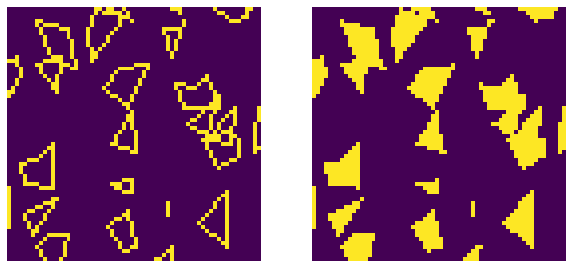

In [240]:
x, y = generate_image(64, 64, 15)
f, axes = plt.subplots(figsize=[10, 5], ncols=2)
for ax, img in zip(axes, [x, y]):
    ax.imshow(img, cmap="viridis")
    ax.axis("off")